# Accessing Sentinel-2 with `sentinelhub` and AWS

The following is tested on Ubuntu 18.

## Preparation

* Install the `sentinelhub` package with e.g. `pip install sentinelhub`.
* Get an account at [sentinel-hub.com](sentinel-hub.com). Then go to "User settings" and create an "OAuth client" to access the search functions. Note down the client secret and client ID.
* Set up an AWS user according to instructions [here](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-2032-Landsat-Commercial-Cloud-Direct-Access-Users-Guide-v2.pdf.pdf) section 2.5.1. In short, create an IAM user with "AmazonS3ReadOnlyAccess" permission. Note down the ID and secret.
* Run the command `sentinel.config --show`. At the end of the print out, it shows where the `config.json` is. Edit that file to add in `sh_client_id` and `sh_client_secret` for the sentinel-hub OAuth client, and `aws_access_key_id` and `aws_secret_access_key` for the AWS client.
  * The official sentinel-hub documentation mentions setting things in the command line. However, this does not seem to handle special characters very well, which is a problem for the access keys. Directly editing the config file is therefore easier.

In [1]:
%matplotlib inline

import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import SHConfig, BBox, CRS, DataCollection

In [2]:
import matplotlib.image as mpimg

In [3]:
import boto3

## Search

Search for images within time window at a certain region. It is also possible to specify additional criteria, such as maximum cloud cover.

In [4]:
config = SHConfig()

In [5]:
from sentinelhub import SentinelHubCatalog

catalog = SentinelHubCatalog(config=config)

Search for the tile containing Addis Ababa, and filter for recent captures with low cloud cover.

In [6]:
# lon/lat, the parameters for BBox are x_min, y_min, x_max, y_max
addis_ababa_bbox = BBox([38.70, 8.95, 38.80, 9.00], crs=CRS.WGS84)
time_interval = '2021-1-1', '2021-03-07'


search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=addis_ababa_bbox,
    time=time_interval,
    query={
        "eo:cloud_cover": {
            "lt": 10
        }
    },

)

In [7]:
results = list(search_iterator)

In [8]:
print(len(results))

18


In [9]:
results[0]

{'stac_version': '0.9.0',
 'stac_extensions': ['eo', 'projection'],
 'id': 'S2B_MSIL2A_20210304T073809_N0214_R092_T37PDK_20210304T103139',
 'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:OGC::CRS84'}},
  'coordinates': [[[[38.159112891161996, 9.045769850758077],
     [38.09053481178766, 8.733745305634404],
     [38.092118442217995, 8.052573734849059],
     [39.08856938761158, 8.05356853432031],
     [39.08879899759758, 9.046723564238105],
     [38.159112891161996, 9.045769850758077]]]]},
 'bbox': [38.09053481178766,
  8.052573734849059,
  39.08879899759758,
  9.046723564238105],
 'properties': {'datetime': '2021-03-04T07:57:37Z',
  'platform': 'sentinel-2b',
  'instruments': ['msi'],
  'constellation': 'sentinel-2',
  'eo:gsd': 10,
  'eo:cloud_cover': 1.38,
  'eo:bands': [{'name': 'B01',
    'common_name': 'coastal',
    'center_wavelength': 0.4427,
    'full_width_half_max': 0.021},
   {'name': 'B02',
    '

## Download

Now setup AWS client and download the images. The official sentinel-hub documentation uses `AwsTile` but it didn't work for me, so I'm using AWS `boto3` directly.

In [10]:
aws_client = boto3.Session().client(
    's3',
    aws_access_key_id=config.aws_access_key_id,
    aws_secret_access_key=config.aws_secret_access_key,
)

In [11]:
path = results[0]['assets']['data']['href']

In [12]:
path = path[len('s3://sentinel-s2-l2a')+1:] # there are probably more proper ways to do this

In [13]:
for band in ['B02', 'B03', 'B04']:
    fname = band + '.jp2'
    print(f'Downloading {path}/R10m/{fname}')
    response = aws_client.get_object(
        Bucket='sentinel-s2-l2a',
        Key=path + 'R10m/' + fname,
        RequestPayer='requester')
    response_content = response['Body'].read()

    with open(fname, 'wb') as file:
        file.write(response_content)


## Visualize the image

Note that the original JP2 files contain a lot of additional information such as location. This is lost in the visualization below. Other libraries like GDAL probably handles this better. If `gdal-bin` is installed, then some of the information can be displayed by e.g. `gdalinfo B02.jp2` (see below). A better workflow might be to use a script like the above to download the images and then use GDAL to do the conversion.

In [14]:
img_b = mpimg.imread('B02.jp2')
img_g = mpimg.imread('B03.jp2')
img_r = mpimg.imread('B04.jp2')

In [15]:
img = np.stack([img_r, img_g, img_b], axis=-1)

The dynamic range of the raw image is very large. Clip and rescale so it is easier to see the features on the ground.

In [16]:
fimg = np.clip(img, 0, 4096).astype(float) / 4096

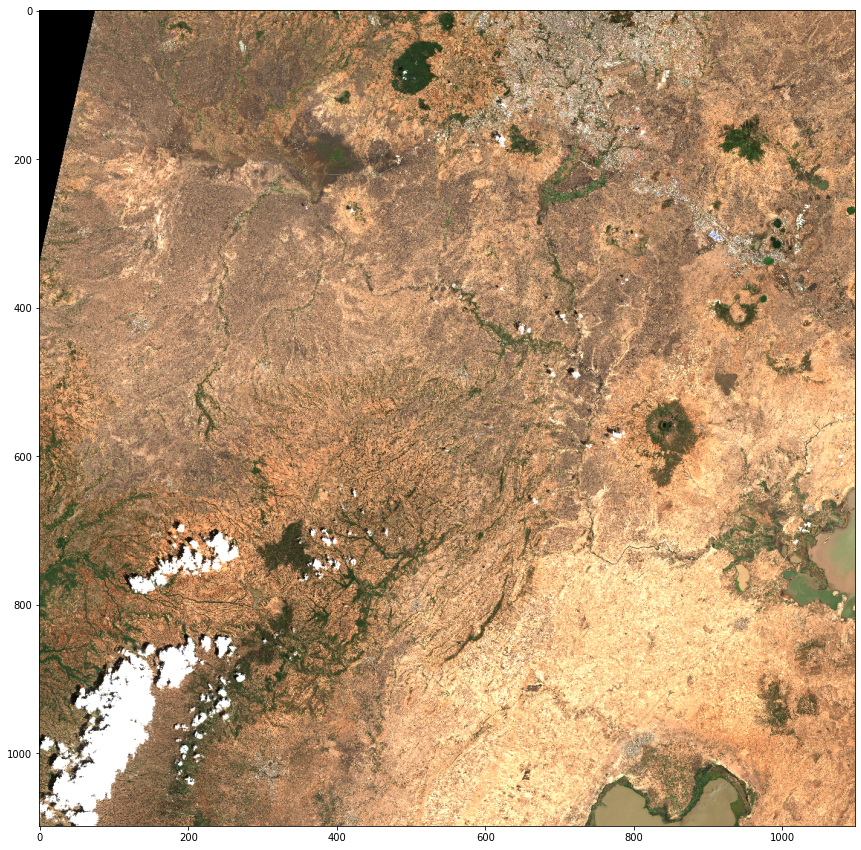

In [17]:
plt.figure(figsize=(15,15))
plt.imshow(fimg[::10, ::10, :]) # taking every 10-th pixel just so we don't have to display a huge image

Example output of `gdalinfo B02.jp2`:
```
Files: B02.jp2
Size is 10980, 10980
Coordinate System is:
PROJCS["WGS 84 / UTM zone 37N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AXIS["Latitude",NORTH],
        AXIS["Longitude",EAST],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",39],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32637"]]
Origin = (399960.000000000000000,1000020.000000000000000)
Pixel Size = (10.000000000000000,-10.000000000000000)
Corner Coordinates:
Upper Left  (  399960.000, 1000020.000) ( 38d 5'23.12"E,  9d 2'44.21"N)
Lower Left  (  399960.000,  890220.000) ( 38d 5'31.59"E,  8d 3' 9.23"N)
Upper Right (  509760.000, 1000020.000) ( 39d 5'19.71"E,  9d 2'48.24"N)
Lower Right (  509760.000,  890220.000) ( 39d 5'18.88"E,  8d 3'12.81"N)
Center      (  454860.000,  945120.000) ( 38d35'23.33"E,  8d32'59.80"N)
Band 1 Block=1024x1024 Type=UInt16, ColorInterp=Gray
  Overviews: 5490x5490, 2745x2745, 1372x1372, 686x686
  Overviews: arbitrary
  Image Structure Metadata:
    COMPRESSION=JPEG2000
    NBITS=15
```